# Character Recognition for Captcha Breaking

Denis Peskov. 2017.  The following notebook uses a subset of the Chars74k  (The website is frequently overloaded http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/) as found in a Kaggle tutorial (https://www.kaggle.com/c/street-view-getting-started-with-julia/data)

## Imports

In [1]:
import PIL.Image
import glob
from scipy import misc
from skimage import color
import numpy as np
import csv
from sklearn.model_selection import train_test_split
import string
from matplotlib import pyplot as plt
import pylab
import collections
import re

#keras specific
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


## Preprocessing

In [2]:
image_list = list()

#read in every image (format is: train-3/123.Bmp)  
#Otherwise, you will read the images in order 1, 10, 100
fn_list = list()
for fn in sorted(glob.glob('train-3/*')):
    a = re.search('(?<=\/)\d+' , fn)
    fn_list.append(int(a.group(0)))

#read in images (6k total), resize to 30x30, and standardize their color
for fn in sorted(fn_list):
    letter = color.rgb2gray(misc.imread('train-3/'+str(fn)+'.Bmp')) 
    small = misc.imresize(letter, [30, 30])
    image_list.append(small)

#read in labels, provided as CSV file    
labels= list()
with open('trainLabels.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        labels.append(row['Class'])

The below logic ensures that the classes are evenly distributed.  This is not used, as using the full dataset provided better results

In [3]:
count = collections.Counter()
even_image= list()
even_label = list()
CLASS_LIMIT = 30

for index, label in enumerate(labels):
    if count[label] < CLASS_LIMIT:
        count.update(label)
        even_image.append(image_list[index])
        even_label.append(label)
            

Generate a dictionary that is used to convert the labels into categorical classes

In [4]:
#A-Z, a-z
char_conv = dict.fromkeys(string.ascii_letters)

#0-9
for i in range(0,10):
    char_conv[str(i)] = i

#for each key assign it unique 0-61 value
i = 0
for char in char_conv.keys():
    char_conv[char] = i
    i = i+1

#inverse the dictionary for backwards conversion
reverse_conv = dict((v,k) for k,v in char_conv.iteritems())

print("Regular", char_conv)
print("\nBackwards", reverse_conv)

Regular {'1': 0, '0': 1, '3': 2, '2': 3, '5': 4, '4': 5, '7': 6, '6': 7, '9': 8, '8': 9, 'A': 10, 'C': 11, 'B': 12, 'E': 13, 'D': 14, 'G': 15, 'F': 16, 'I': 17, 'H': 18, 'K': 19, 'J': 20, 'M': 21, 'L': 22, 'O': 23, 'N': 24, 'Q': 25, 'P': 26, 'S': 27, 'R': 28, 'U': 29, 'T': 30, 'W': 31, 'V': 32, 'Y': 33, 'X': 34, 'Z': 35, 'a': 36, 'c': 37, 'b': 38, 'e': 39, 'd': 40, 'g': 41, 'f': 42, 'i': 43, 'h': 44, 'k': 45, 'j': 46, 'm': 47, 'l': 48, 'o': 49, 'n': 50, 'q': 51, 'p': 52, 's': 53, 'r': 54, 'u': 55, 't': 56, 'w': 57, 'v': 58, 'y': 59, 'x': 60, 'z': 61}

Backwards {0: '1', 1: '0', 2: '3', 3: '2', 4: '5', 5: '4', 6: '7', 7: '6', 8: '9', 9: '8', 10: 'A', 11: 'C', 12: 'B', 13: 'E', 14: 'D', 15: 'G', 16: 'F', 17: 'I', 18: 'H', 19: 'K', 20: 'J', 21: 'M', 22: 'L', 23: 'O', 24: 'N', 25: 'Q', 26: 'P', 27: 'S', 28: 'R', 29: 'U', 30: 'T', 31: 'W', 32: 'V', 33: 'Y', 34: 'X', 35: 'Z', 36: 'a', 37: 'c', 38: 'b', 39: 'e', 40: 'd', 41: 'g', 42: 'f', 43: 'i', 44: 'h', 45: 'k', 46: 'j', 47: 'm', 48: 'l', 

Convert the lists of labels and images into numpy arrays for keras/other ML libraries

In [5]:
#even_image = np.array(even_image)
image_list = np.array(image_list)

#for labels    
#even_label = np.array([char_conv[label] for label in even_label])
labels = np.array([char_conv[label] for label in labels])

n


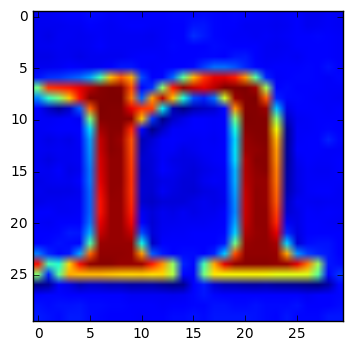

8


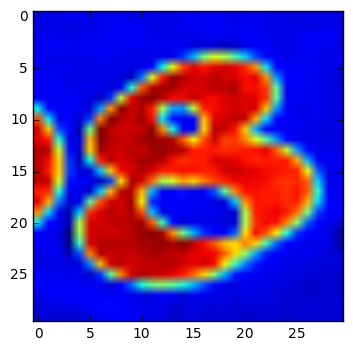

T


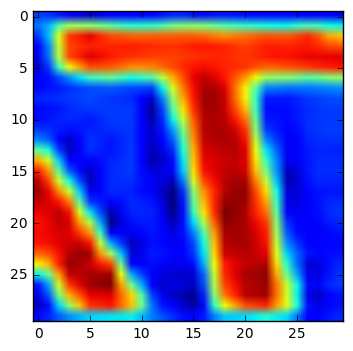

I


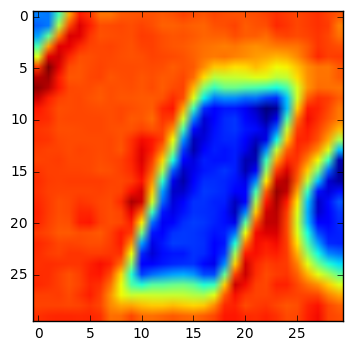

R


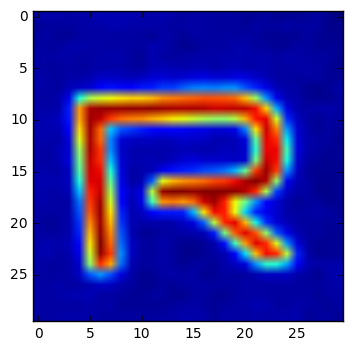

In [6]:
#print out a sample of the images and the labels to make sure everything was imported successfully
for i in range(0, 5):
    print(reverse_conv[labels[i]])
    plt.imshow(image_list[i])
    pylab.show()

Split the data into test/train data, ensure that everything is a float, and normalize by 255 (since image data)

In [7]:
#x_train, x_test, y_train, y_test = train_test_split(even_image, even_label, test_size=0.05)
x_train, x_test, y_train, y_test = train_test_split(image_list, labels, test_size=0.1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 62)
y_test = keras.utils.to_categorical(y_test, 62)

## Neural Network

### Set-up

Set the high level parameters.  62 classes (26 letters + 26 uppercase + 10 numerical digits).  15 epochs was hand-tuned based on validation accuracy.  Lower batch size is more granular but takes more epochs to converge; at convergence doesn't really matter.  Setting image size to 30x30 was arbitrary.  No difference between 50x50

In [8]:
batch_size =32
num_classes = 62
epochs = 15
img_rows, img_cols = 30, 30 

The if/else allows formats other than TF to work (the else statement is sufficient for TF).  Reshaping is necessary for keras.  

In [9]:
if K.image_dim_ordering == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (5654, 30, 30, 1)
5654 train samples
629 test samples


The following architecture has convolution layers that move across the image.  
MaxPooling reduces the amount of parameters in these convolutions.  
Flatten converts output of many dimensions into a very long one dimensional vector.    
Dropout prevents overfitting by literally dropping parameters a fraction of the time  
Categorical crossentropy works for this task.  Something like KL Divergence provides similar results.   
The main optimizers don't cause major outcome changes, so default settings should be fine. 

In [10]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3),
input_shape=input_shape, activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
metrics=['accuracy'])

#print out the model
model.summary()

#For the pretty architecture image, uncomment this:  
#(You will have to pip install pydot and graphviz and brew_install graphviz)
#import pydot
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2769024   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

Here's an alternate model (similar architecture only ginormous).  The training time increases dramatiaclly and results are not notably better.  Hence it is commented out    

In [ ]:
'''
model = Sequential()

model.add(Conv2D(128, (3,3), input_shape=input_shape, activation = 'relu'))
model.add(Conv2D(128,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3), activation = 'relu'))
model.add(Conv2D(256,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512,(3,3), activation = 'relu'))
#model.add(Conv2D(512,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# convert convolutional filters to flat so they can be feed to fully connected layers
model.add(Flatten())

model.add(Dense(2048, activation='relu'))
model.add(keras.layers.advanced_activations.LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))

model.add(Dense(2048, activation='relu'))
model.add(keras.layers.advanced_activations.LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
metrics=['accuracy'])
'''

### Train

In [12]:
model.fit(x_train, y_train,
batch_size=batch_size,
epochs=epochs,
verbose=1,
validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 5654 samples, validate on 629 samples
Epoch 1/15
5654/5654 [==============================] - 113s - loss: 3.6585 - acc: 0.1417 - val_loss: 2.8717 - val_acc: 0.3736
Epoch 2/15
5654/5654 [==============================] - 112s - loss: 2.6959 - acc: 0.3438 - val_loss: 2.0302 - val_acc: 0.5072
Epoch 3/15
5654/5654 [==============================] - 121s - loss: 2.1866 - acc: 0.4268 - val_loss: 1.6381 - val_acc: 0.5978
Epoch 4/15
5654/5654 [==============================] - 127s - loss: 1.8666 - acc: 0.4993 - val_loss: 1.4776 - val_acc: 0.6375
Epoch 5/15
5654/5654 [==============================] - 128s - loss: 1.7149 - acc: 0.5228 - val_loss: 1.3536 - val_acc: 0.6566
Epoch 6/15
5654/5654 [==============================] - 120s - loss: 1.5348 - acc: 0.5752 - val_loss: 1.2535 - val_acc: 0.6741
Epoch 7/15
5654/5654 [==============================] - 118s - loss: 1.4370 - acc: 0.5911 - val_loss: 1.2122 - val_acc: 0.6836
Epoch 8/15
5654/5654 [==============================] - 698s - l

## Classify

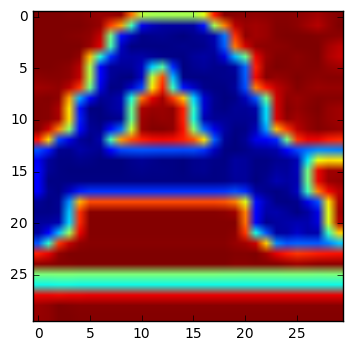

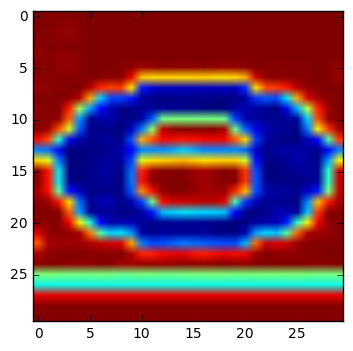

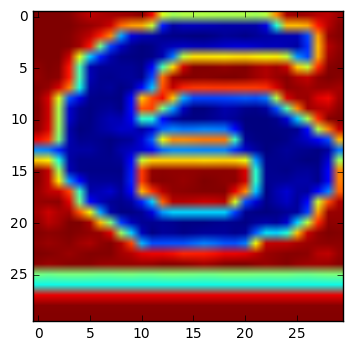

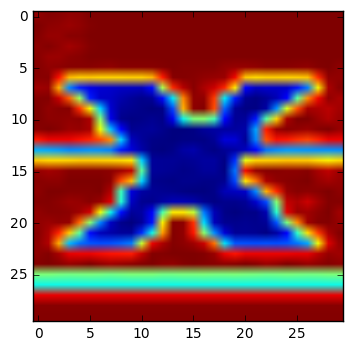

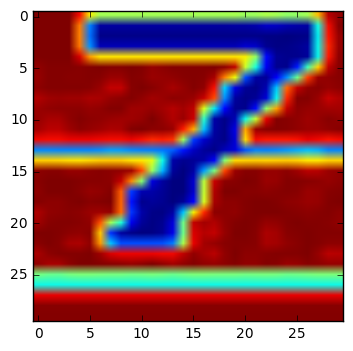

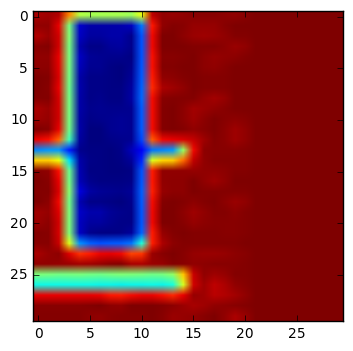

In [13]:
#adjust crop to work on the specific captcha
image = PIL.Image.open("captcha2.png")
image = image.crop([50, 0, image.size[0]-50, image.size[1]])

image.show()

height = image.size[1]
width = image.size[0]

test = []
for i in range(0,6):
    i = i*(image.size[0]/6)
    #create 6 bounding boxes and limit the height of the box
    box = [i, height*7/32, i+width/6, height*34/48]
    letter = image.crop(box)
    #preprocess for consistency with NN
    letter = color.rgb2gray(np.asarray(letter))
    letter = misc.imresize(letter, [img_rows, img_cols])
    plt.imshow(letter)
    pylab.show()
    letter = letter.reshape(img_rows, img_cols, 1)
    test.append(letter)


test = np.array(test)
test= test.astype('float32')
test /= 255

In [14]:
print(model.predict_classes(test))
print([reverse_conv[value] for value in model.predict_classes(test)])
print('\n')
results = model.predict(test)
#results

for result in results:
    #print(result.argsort()[-3:])
    print([reverse_conv[value] for value in result.argsort()[-5:]])
#model.summary()

6/6 [==============================] - 0s
[10 39 23 60 56 18]
6/6 [==============================] - 0s
['A', 'e', 'O', 'x', 't', 'H']


['B', 'I', 'a', '4', 'A']
['O', 'b', 'B', 'a', 'e']
['0', 'g', 'e', 'o', 'O']
['I', 'K', 'N', 'X', 'x']
['f', 'l', 'I', 'i', 't']
['k', 'h', 'L', 'l', 'H']
